
Курсовая работа на тему:
«Анализ параметров выходных нейронов глубоких нейронных сетей»
Архитектура № 2

Импортирование библиотек

In [1]:
import numpy as np
import torchvision
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
import seaborn as sns
import pandas as pd

Загрузка датасета MNIST

In [2]:
MNIST_train = torchvision.datasets.MNIST('mnist_data', train=True, download=True)
MNIST_test = torchvision.datasets.MNIST('mnist_data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 205950856.21it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102744439.21it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 95777357.03it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21261750.86it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [3]:
MNIST_train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [4]:
print(MNIST_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train


In [5]:
print(MNIST_test)

Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test


Преобразовывание данных: X_train и X_test — это изображения цифр в виде двумерных тензоров размера 28x28, приведенных к типу данных float. y_train и y_test — это метки классов, представленные в виде одномерных тензоров.

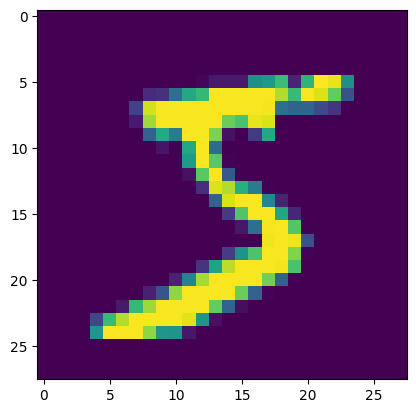

label - 5 - five


In [6]:
X_train = MNIST_train.data.float()
y_train = MNIST_train.targets
X_test = MNIST_test.data.float()
y_test = MNIST_test.targets
plt.imshow(X_train[0, :, :])
plt.show()
print('label -', MNIST_train.classes[y_train[0]])

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

Создание класса MNIST_ConV для сверточной нейронной сети, унаследованной от класса torch.nn.Module: три сверточных слоя conv1, conv2, conv3, три слоя batch normalization, три слоя ReLU, три слоя MaxPool2d, три полносвязных слоя, слой Dropout.

In [8]:
class MNIST_ConvNet(nn.Module):
    def __init__(self):
        super(MNIST_ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=64*3*3, out_features=128)
        self.relu4 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        x = x.view(-1, 64*3*3)
        
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        return x
mnist_conv = MNIST_ConvNet().cuda()


Обучение модели и вывод метрик

In [9]:
from sklearn.metrics import f1_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_tensor = X_train.cuda()
y_train_tensor = y_train.cuda()
X_test_tensor = X_test.cuda()
y_test_tensor = y_test.cuda()

batch_size = 100
num_epochs = 20
learning_rate = 0.001

mnist_conv.cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_conv.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

test_accuracy_history = []
test_loss_history = []
test_f1_score_history = []

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train_tensor[batch_indexes]
        y_batch = y_train_tensor[batch_indexes]
        
        preds = mnist_conv(X_batch) 
        
        loss_value = criterion(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    with torch.no_grad():
        test_preds = mnist_conv(X_test_tensor)
        test_loss = criterion(test_preds, y_test_tensor)
        test_loss_history.append(test_loss.item())

        accuracy = (test_preds.argmax(dim=1) == y_test_tensor).float().mean()
        test_accuracy_history.append(accuracy.item())
        preds_classes = torch.argmax(test_preds, dim=1)
        f1 = f1_score(y_test_tensor.cpu().numpy(), preds_classes.cpu().numpy(), average='weighted')
        test_f1_score_history.append(f1)
        print(f"Epoch {epoch}: Test accuracy: {accuracy.item()}, Test loss: {test_loss.item()}, F1-score: {f1}") 

Using device: cuda
Epoch 0: Test accuracy: 0.9754999876022339, Test loss: 0.08505291491746902, F1-score: 0.9755468126388327
Epoch 1: Test accuracy: 0.9821999669075012, Test loss: 0.057113856077194214, F1-score: 0.982186837764235
Epoch 2: Test accuracy: 0.9847999811172485, Test loss: 0.05103744938969612, F1-score: 0.9848028781924815
Epoch 3: Test accuracy: 0.9866999983787537, Test loss: 0.043852973729372025, F1-score: 0.9866850829836127
Epoch 4: Test accuracy: 0.988599956035614, Test loss: 0.041425496339797974, F1-score: 0.988600099167651
Epoch 5: Test accuracy: 0.9873999953269958, Test loss: 0.039841387420892715, F1-score: 0.9873967313695308
Epoch 6: Test accuracy: 0.9878000020980835, Test loss: 0.037914685904979706, F1-score: 0.987800428953248
Epoch 7: Test accuracy: 0.9887999892234802, Test loss: 0.03624499961733818, F1-score: 0.9887968968362174
Epoch 8: Test accuracy: 0.9892999529838562, Test loss: 0.04019700735807419, F1-score: 0.9892940802608129
Epoch 9: Test accuracy: 0.988399982

Вывод графического отражения метрики F1-score 

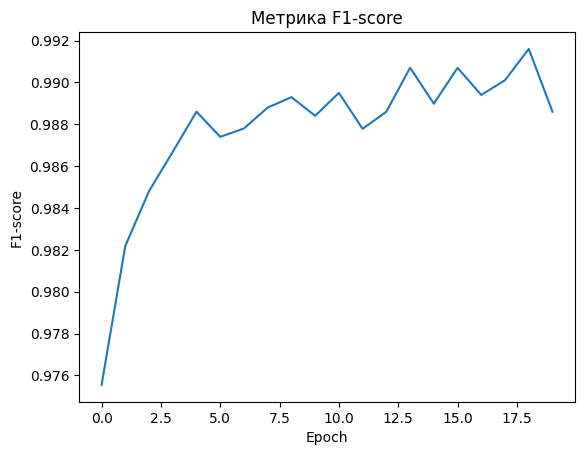

In [10]:
plt.plot(test_f1_score_history)
plt.title("Метрика F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.show()

Вывод весов последнего слоя нейронной сети

In [12]:
last_layer_weights = mnist_conv.fc2.weight
print(last_layer_weights)

Parameter containing:
tensor([[ 0.0513, -0.0744, -0.2068,  ...,  0.1623,  0.1000, -0.0370],
        [-0.0516,  0.0496, -0.1236,  ..., -0.2692,  0.0012, -0.0346],
        [-0.0676, -0.0380,  0.0583,  ...,  0.1698, -0.1747, -0.0149],
        ...,
        [-0.0401, -0.0852, -0.1949,  ..., -0.2701,  0.1172, -0.0833],
        [ 0.0469,  0.0783, -0.1711,  ..., -0.0657, -0.1782,  0.0321],
        [ 0.0696, -0.0920,  0.1026,  ..., -0.1053,  0.0904, -0.0783]],
       device='cuda:0', requires_grad=True)


Вывод смещений последнего слоя нейронной сети

In [13]:
last_layer_bias = mnist_conv.fc2.bias
print(last_layer_bias)

Parameter containing:
tensor([ 0.0302,  0.3850,  0.0820,  0.0597, -0.0590, -0.0147, -0.1108, -0.0410,
         0.0226, -0.0689], device='cuda:0', requires_grad=True)


Графическое отображение результатов обучения модели нейронной сети

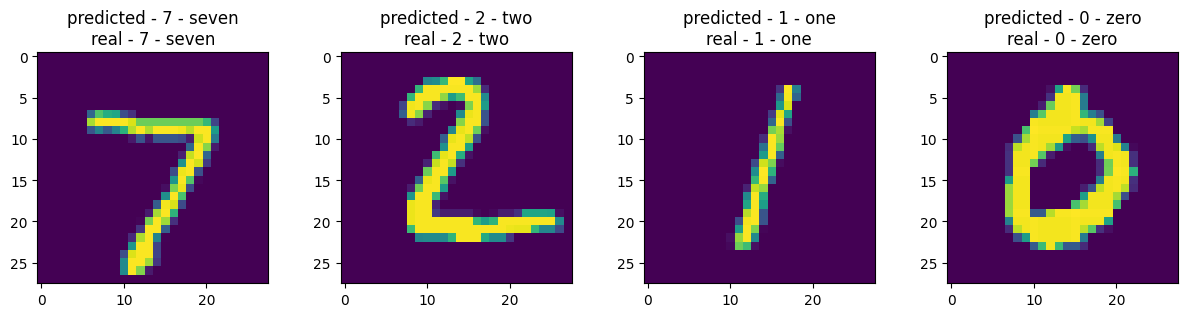

In [14]:
def show_sample(model, X, y, dataset):
    y_pred = model.forward(X)
    X = X.cpu().numpy()
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    for i in range(4):
        ax[i].imshow(X[i].reshape(28, 28))
        ax[i].set_title(f'predicted - {dataset.classes[y_pred[i].argmax()]}\nreal - {dataset.classes[y[i]]}')
    
show_sample(mnist_conv, X_test.cuda(), y_test, MNIST_test)

Вывод тепловой карты (heatmap) для матрицы попарных классификационных ошибок модели на тестовом наборе данных. 

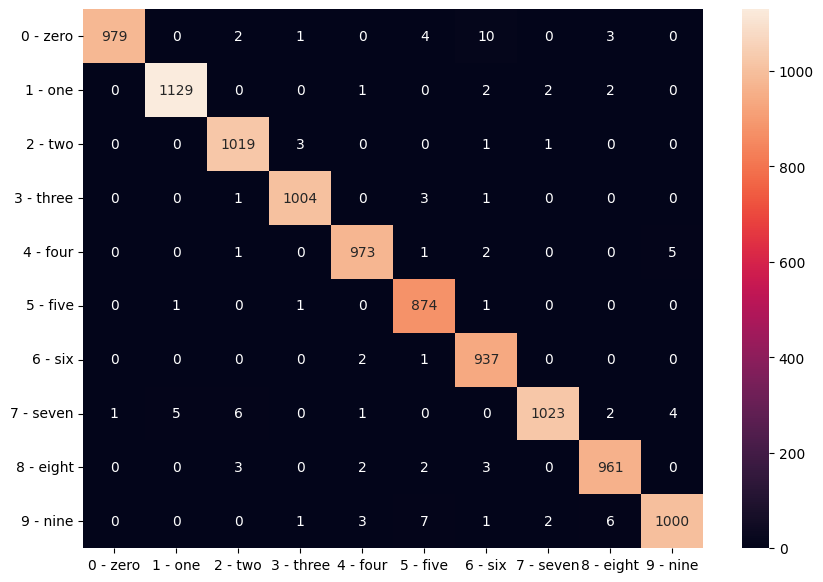

In [15]:
def show_matrix(model, X, y, dataset):
    heat_map_matrix = torch.zeros((len(dataset.classes), len(dataset.classes)))
    y_pred = model.forward(X).argmax(axis=1)
    for i in range(len(y)):
        heat_map_matrix[y_pred[i], y[i]] += 1
    heat_map_matrix = pd.DataFrame(heat_map_matrix, columns=dataset.classes)
    heat_map_matrix.index = dataset.classes
     
    plt.figure(1, (10, 7))
    sns.heatmap(heat_map_matrix, annot=True, fmt='g')
    plt.show()
show_matrix(mnist_conv, X_test.cuda(), y_test, MNIST_test)

Вывод графического отображения первого сверточного слоя

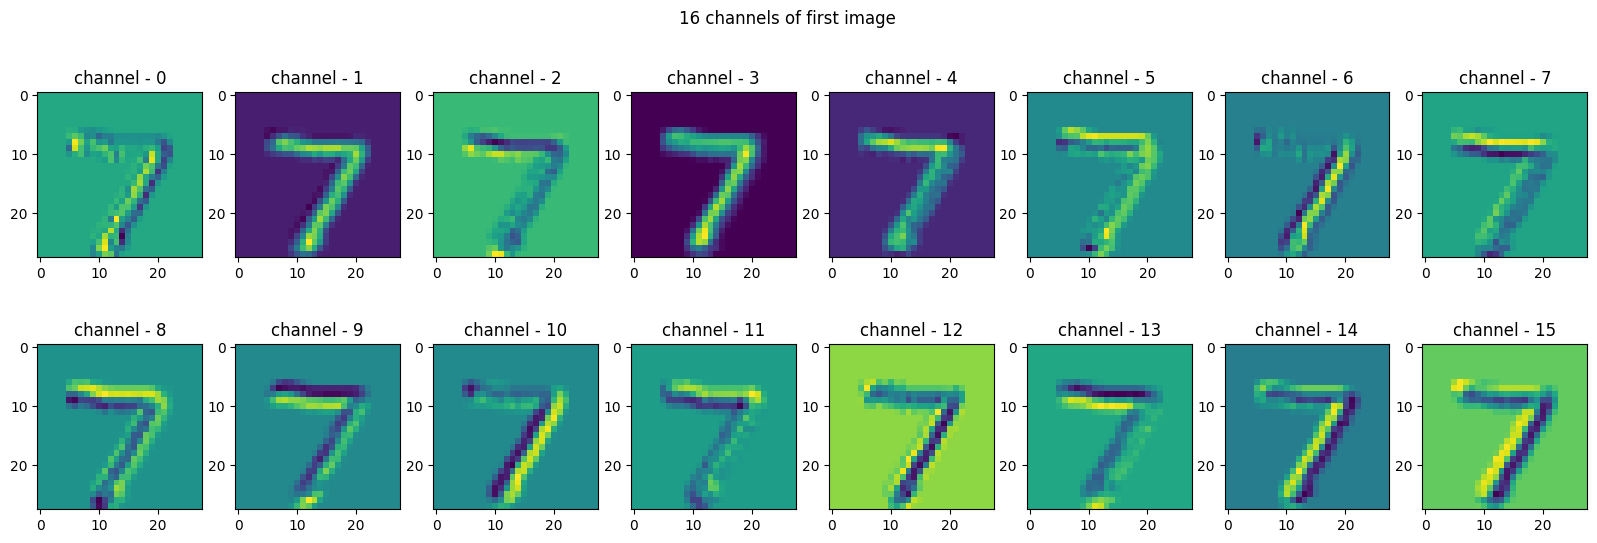

In [16]:
def show_first_conv(model, X, y, dataset):
    with torch.no_grad():
        first_conv = model.conv1(X)
        fig, ax = plt.subplots(2, 8, figsize=(20, 6))
        fig.suptitle(f'{first_conv[0].size(0)} channels of first image')
        for i in range(first_conv[0].size(0)):
            row = i // 8
            col = i % 8
            if row < 2:
                first_conv_arr = first_conv.cpu().numpy()
            else:
                break
            ax[row, col].imshow(first_conv_arr[0][i])
            ax[row, col].set_title(f'channel - {i}')
    plt.show()

show_first_conv(mnist_conv, X_test.cuda(), y_test, MNIST_test)
